In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-hw3/cifar_hw3/y_train.npy
/kaggle/input/cifar10-hw3/cifar_hw3/y_test.npy
/kaggle/input/cifar10-hw3/cifar_hw3/y_val.npy
/kaggle/input/cifar10-hw3/cifar_hw3/x_test.npy
/kaggle/input/cifar10-hw3/cifar_hw3/x_val.npy
/kaggle/input/cifar10-hw3/cifar_hw3/x_train.npy


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


In [27]:


x_train = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/x_train.npy')
y_train = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/y_train.npy')
x_val = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/x_val.npy')
y_val = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/y_val.npy')
x_test = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/x_test.npy')
y_test = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/y_test.npy')

#appiattimento delle classi
y_train = y_train.flatten()
y_test = y_test.flatten()
y_val = y_val.flatten()

# Sottocampionamento bilanciato con stratify
x_train, _, y_train, _ = train_test_split(x_train, y_train, train_size=5000, stratify=y_train, random_state=42)
x_val, _, y_val, _ = train_test_split(x_val, y_val, train_size=1000, stratify=y_val, random_state=42)
x_test, _, y_test, _ = train_test_split(x_test, y_test, train_size=1000, stratify=y_test, random_state=42)

#appiattimento delle immagini
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)

In [28]:
hyperparams = {
    'classifier': 'MLP',
    'hidden_layer_sizes': [(100,), (256, 128), (512, 256, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.0005, 0.001, 0.01],
    'max_iter': 300
}


In [29]:
def pipeline_mlp(x_train, y_train, x_val, y_val, hyperparams):
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    pca = PCA(n_components=100) 
    x_train = pca.fit_transform(x_train)
    x_val = pca.transform(x_val)

    param_grid = {
        'hidden_layer_sizes': hyperparams['hidden_layer_sizes'],
        'activation': hyperparams['activation'],
        'solver': hyperparams['solver'],
        'learning_rate_init': hyperparams['learning_rate_init']
    }

    modello_base = MLPClassifier(max_iter=hyperparams['max_iter'], early_stopping=True, random_state=42)

    grid_search = GridSearchCV(modello_base, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train, y_train)

    #estrazione del modello migliore
    modello_migliore = grid_search.best_estimator_

    #Predizione sul training set e sul validation set

    pred_train = modello_migliore.predict(x_train)
    pred_val = modello_migliore.predict(x_val)

    #Calcolo delle metriche per il training set

    train_accuracy = accuracy_score(y_train, pred_train)
    f1_train = f1_score(y_train, pred_train, average='macro')
    matrice_confusione_train = confusion_matrix(y_train, pred_train)

    #calcolo delle metriche per il validation test
    
    validation_accuracy = accuracy_score(y_val, pred_val)
    f1_val = f1_score(y_val, pred_val, average='macro')
    matrice_confusione_val = confusion_matrix(y_val, pred_val)

    return train_accuracy, f1_train, matrice_confusione_train, validation_accuracy, f1_val, matrice_confusione_val, modello_migliore, grid_search.best_params_


MIGLIOR CONFIGURAZIONE TROVATA:
{'activation': 'relu', 'hidden_layer_sizes': (512, 256, 128), 'learning_rate_init': 0.01, 'solver': 'adam'}

 TRAINING SET
Accuracy: 0.9304
F1 Score: 0.9302
matrice di confusione:


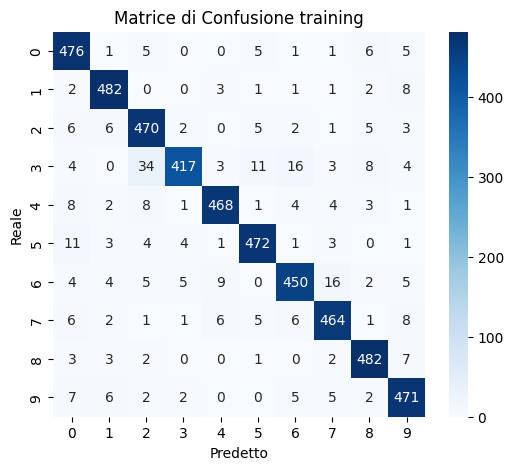

 VALIDATION SET
Accuracy: 0.3580
F1 Score: 0.3465
matrice di confusione:


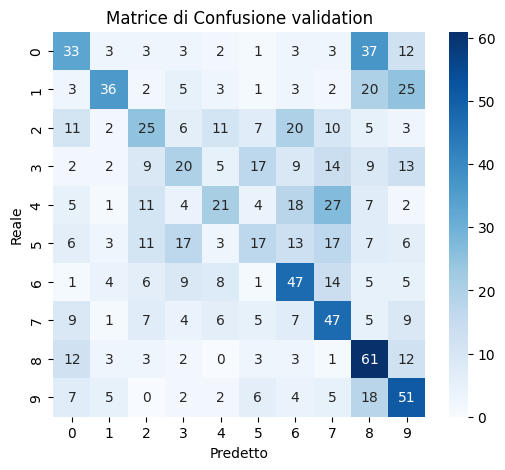

VALUTAZIONE FINALE SUL TEST SET
Accuracy: 0.3240
F1 Score: 0.3213


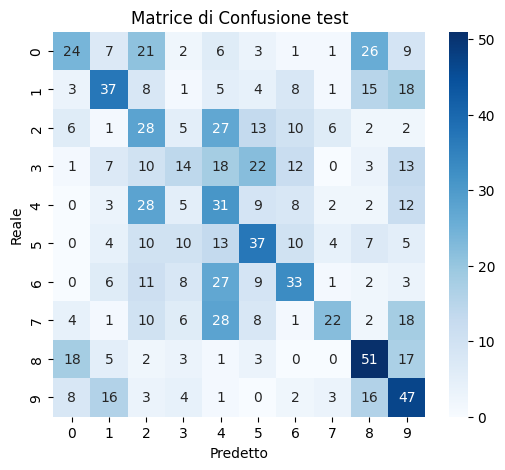

In [30]:

train_accuracy, f1_train, matrice_confusione_train, validation_accuracy, f1_val, matrice_confusione_val, modello_migliore, best_params = pipeline_mlp(
    x_train, y_train, x_val, y_val, hyperparams
)

# Stampa delle metriche
print("MIGLIOR CONFIGURAZIONE TROVATA:")
print(best_params)
print()

print(" TRAINING SET")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {f1_train:.4f}")
print("matrice di confusione:")
plt.figure(figsize=(6, 5))
sns.heatmap(matrice_confusione_train, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice di Confusione training")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

print(" VALIDATION SET")
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"F1 Score: {f1_val:.4f}")
print("matrice di confusione:")
plt.figure(figsize=(6, 5))
sns.heatmap(matrice_confusione_val, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice di Confusione validation")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()




# Uniamo training + validation
x_train = np.concatenate([x_train, x_val])
y_train = np.concatenate([y_train, y_val])

# Standardizzazione
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Modello finale con i migliori parametri
modello_finale = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    activation=best_params['activation'],
    solver=best_params['solver'],
    learning_rate_init=best_params['learning_rate_init'],
    max_iter=hyperparams['max_iter'],
    early_stopping=True,
    random_state=42
)

# Allenamento completo
modello_finale.fit(x_train, y_train)

# Valutazione sul test set
pred_test = modello_finale.predict(x_test)

test_accuracy = accuracy_score(y_test, pred_test)
test_f1 = f1_score(y_test, pred_test, average='macro')
matrice_confusione_test = confusion_matrix(y_test, pred_test)


print("VALUTAZIONE FINALE SUL TEST SET")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
plt.figure(figsize=(6, 5))
sns.heatmap(matrice_confusione_test, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice di Confusione test")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()
